In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date 
import requests
import urllib.request, json
import os
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import csv
from scipy.stats import ttest_ind

In [23]:
#dates for in-sample analysis
df = yf.download("BAYN.DE", start="2001-01-01", end="2010-12-31")
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-23,56.103260,56.103260,55.375027,55.621052,39.278492,887909
2010-12-27,55.758823,55.847393,54.115387,54.981392,38.826775,1135094
2010-12-28,54.823936,55.207733,54.607433,54.833775,38.722530,724065
2010-12-29,55.109322,55.375027,54.823936,54.971550,38.819817,981947
2010-12-30,55.099483,55.158527,53.977612,54.420456,38.430653,1211095


In [24]:
df = df.drop(['High', 'Low', 'Volume', 'Close'], 1)
stock=df["Adj Close"]


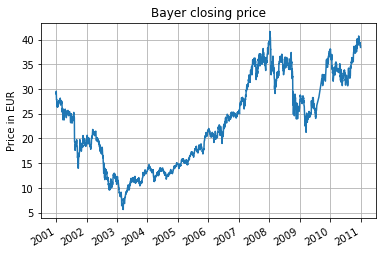

In [25]:
df['Adj Close'].plot(kind = 'line',
             legend = False,
             grid = True)
plt.xlabel('')
plt.ylabel('Price in EUR')
plt.title('Bayer closing price')
plt.show()

In [26]:
# Calculating the short (faster) simple moving average
short_sma = df["Adj Close"].rolling(window=3).mean()


In [27]:
# Calculating the intermediate simple moving average
middle_sma = df["Adj Close"].rolling(window=16).mean()


In [28]:
# Calculating the long-term (slower) simple moving average
long_sma = df["Adj Close"].rolling(window=72).mean()


In [29]:
#create columns
df["MA3"] = short_sma
df["MA16"] = middle_sma
df["MA72"] = long_sma

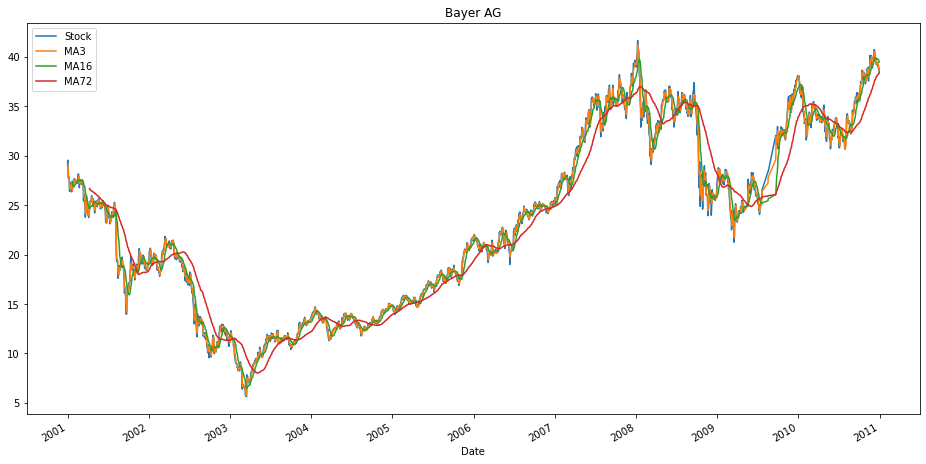

In [30]:
plt.figure(figsize=(16,8))
df["Adj Close"].plot(label= "Stock")
df["MA3"].plot(label="MA3")
df["MA16"].plot(label="MA16")
df["MA72"].plot(label="MA72")
plt.title('Bayer AG')
plt.legend()

In [31]:
#Algorithm for MAC strategy
Buy = [] #if day after MA4>MA17>MA74 and the day before MA4<MA17<MA77 BUY signal
Sell = [] #if the day after MA4<MA17<MA74 and the day before MA4>MA17>MA74 SELL signal
position_long = False
position_short =False
for i in range(len(df)):
    if df.MA3.iloc[i] > df.MA16.iloc[i] and df.MA16.iloc[i] > df.MA72.iloc[i] and position_long== True and position_short==False:
        Buy.append(i)
        position_long=True
    elif position_long==True and df.MA3.iloc[i] < df.MA16.iloc[i] and df.MA16.iloc[i] < df.MA72.iloc[i] :
        Sell.append(i)
        position_long=False
    elif df.MA3.iloc[i] < df.MA16.iloc[i] and df.MA16.iloc[i] < df.MA72.iloc[i] and position_long== False and position_short==False:
        Sell.append(i)
        position_short=True
    elif position_short==True and df.MA3.iloc[i] > df.MA16.iloc[i] and df.MA16.iloc[i] > df.MA72.iloc[i]:
        Buy.append(i)
        position_short=False
        

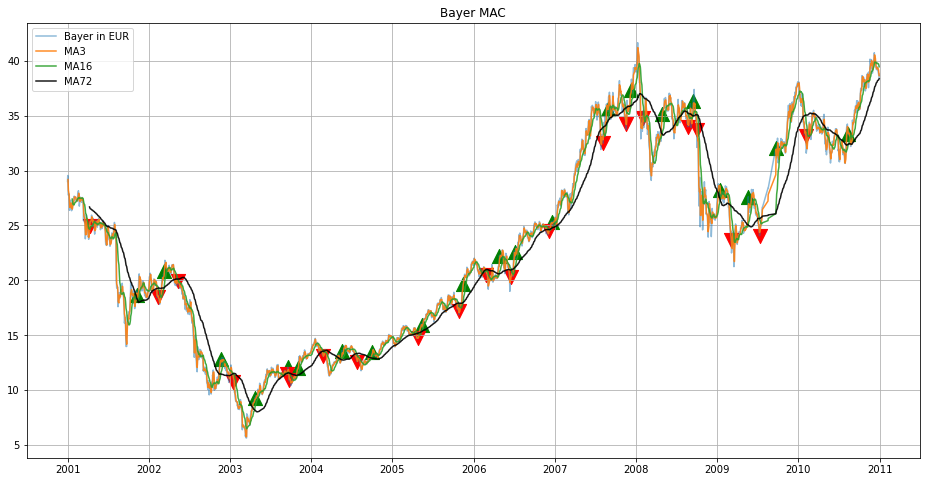

In [32]:
plt.figure(figsize=(16,8))
plt.plot(df["Adj Close"], label= "Bayer in EUR", alpha=0.5)
plt.plot(df["MA3"], label="MA3", alpha=0.9,)
plt.plot(df["MA16"], label="MA16", alpha=0.9)
plt.plot(df["MA72"], label="MA72", alpha=0.9, color= "k")
plt.scatter(df.iloc[Buy].index, df.iloc[Buy]["Adj Close"],marker="^", s=200, color="g")
plt.scatter(df.iloc[Sell].index, df.iloc[Sell]["Adj Close"],marker="v",s=200, color="r")           
plt.legend()
plt.grid()
plt.title("Bayer MAC")
plt.show()

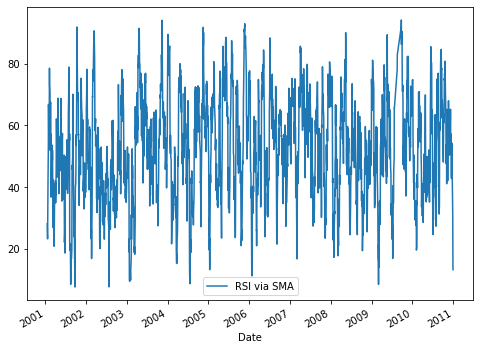

In [36]:
# Window length for moving average

window_length = 14
AdjClose_delta = df['Adj Close'].diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = AdjClose_delta.clip(lower=0), AdjClose_delta.clip(upper=0).abs()

# Calculate the RSI based on SMA

roll_up = up.rolling(window_length).mean()
roll_down = down.rolling(window_length).mean()
rs = roll_up / roll_down
rsi_sma = 100.0 - (100.0 / (1.0 + rs))

#Compare graphically 

plt.figure(figsize=(8, 6))
rsi_sma.plot()
plt.legend(["RSI via SMA"])
plt.show()

In [37]:
#performance of the stock price vs performance of SMAC strategy
#the longer the moving average period the longer the lag
#1 portfolio return is based on the log function of the Adj close difference of price changes with a prior day in percentage
#2 the strategy return is equal to the position considering the next day price to buy the stock
def strategy(df,Long1,Long2):
    df=df.copy()
    df["dayret"] = np.log(1+df["Adj Close"].pct_change())
    df["Long1"]= df["MA3"] > df["MA16"]
    df["Long2"]= df["MA16"] > df["MA72"]
    df["Signal"] = np.where(df.Long1.shift(1)==True, df.Long2.shift(1)==True, 0.0)
    df["Position"] = df["Signal"].diff()
    df["Stra_ret"]= df["Signal"] * df["dayret"]
    return df

In [38]:
def performance(df):
    return np.exp(df[["dayret", "Stra_ret"]].sum())-1
strategy(df,1,2).tail(15)

,Open,Adj Close,MA3,MA16,MA72,dayret,Long1,Long2,Signal,Position,Stra_ret
Date,,,,,,,,,,,
2010-12-09,58.160015,40.501598,40.543297,39.818814,37.555501,-0.005817,True,True,1.0,0.0,-0.005817
2010-12-10,57.559719,40.369560,40.536348,39.886137,37.635565,-0.003265,True,True,1.0,0.0,-0.003265
2010-12-13,56.998783,39.820545,40.230568,39.865288,37.714325,-0.013693,True,True,1.0,0.0,-0.013693
2010-12-14,56.300079,39.632915,39.941007,39.862248,37.787006,-0.004723,True,True,1.0,0.0,-0.004723
2010-12-15,55.906441,39.563419,39.672293,39.877450,37.858720,-0.001755,False,True,1.0,0.0,-0.001755
2010-12-16,55.886757,39.382729,39.526354,39.844440,37.928167,-0.004578,False,True,0.0,-1.0,-0.000000
2010-12-17,56.024532,39.229839,39.391996,39.789277,37.990133,-0.003890,False,True,0.0,0.0,-0.000000
2010-12-20,55.778507,39.181198,39.264589,39.736288,38.046984,-0.001241,False,True,0.0,0.0,-0.000000
2010-12-21,55.650574,39.424431,39.278489,39.765389,38.101421,0.006189,False,True,0.0,0.0,0.000000


In [753]:
#outperform and underperfom 
performance(strategy(df,1,2)).tail()

dayret      0.324464
Stra_ret    0.548231
dtype: float64

Text(0.5, 1.0, 'Bayer')

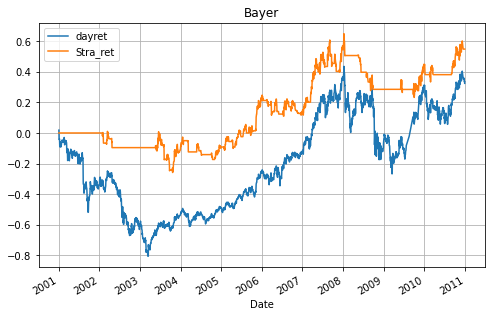

In [726]:
# cumulative return plot
(np.exp(df[["dayret","Stra_ret"]].cumsum())-1).plot(grid=True,figsize=(8,5))
plt.title("Bayer")

In [650]:
#Stock annual volatility 250 trading days
StockDailyReturns=np.log(1+df["Adj Close"].pct_change())
StockVar=StockDailyReturns.var()
np.sqrt(StockVar * 250)

0.35678360330210485

In [657]:
#Daily cumulative return
cumu_return=np.exp(df[["dayret","Stra_ret"]].cumsum())-1
cumu_return.head()

,dayret,Stra_ret
Date,,
2001-01-01,NaN,NaN
2001-01-02,0.018436,0.0
2001-01-03,-0.001253,0.0
2001-01-04,-0.042420,0.0
2001-01-05,-0.042420,0.0


In [661]:
#Tests to confirm the formula
returns= df["Adj Close"].pct_change()
cum_return=(returns + 1).prod()-1
cum_return

0.32446379838803185